**List 7** - Algorithms and Data Structures 2021/22, WUST - F13

*Author:* Mateusz Machaj, 262288

*Date:* 24.01.2022

# Import

There are the imports I use. `graphviz` have to be installed both in Python (`pip install graphviz`) and on OS (`winget install graphviz` for Windows), with added executable file to the *PATH*.

In [7]:
from __future__ import annotations

import queue
import sys
import warnings
from collections.abc import Iterator
from typing import Any, Dict, List, Optional, Set, Tuple, Union

# grapviz have to be installed in Program Files and added to the PATH
import graphviz


The following lines are to change the warning message format and skip the traceback info.

In [8]:
def no_traceback_warning(
    message, category, filename=None, lineno=None, file=None, line=None
):
    """
    Give the no-traceback warning format.
    `warnings` library convention is used.
    """
    return "{cat}: {mess}\n".format(cat=category.__name__, mess=message)


warnings.formatwarning = no_traceback_warning


Moreover, a hashable checker. It is not explcitely avaliable in pure Python.

In [9]:
def hashable(variable: Any) -> bool:
    """Check if the variable is hashable.

    Args:
        variable (Any): Variable to be checked.

    Returns:
        bool: Info about being hashable.
    """
    try:
        hash(variable)
    except TypeError:
        return False
    return True


-----------------------

# Task 1

_**Graph class implementation**_

-----------------------

The basic graph with the methods from the lecture [[1]](#ref1) is consists of the nodes. These classes are partially copied from the referenced lecture. However, there are some changes and I have added node and edge deletion. There is also an option to create **directed** or **undirected** graph.

In the second one we cannot connect one node with itself (by edge), because that is the rule from definition. The first option allows it though.

In my implementation adding a node with the key that already exist does not affect the structure. Nothing changes. Similarly, adding the existing edge only updates its weight. 

## Node

I begin with creating the node class used later in the graph. It will contain also the features required for searching algorithms in the next tasks.

I do not use unncessary `get` and `set` methods for attributes, because the code is written with respect to Python conventions.

In [10]:
class Node:
    """Graph node class.

    Basic attributes:
        key (Any): Node's key.
        neighbors (dict): Nodes connected to this one.
        neighbor_for (set): Set of nodes pointing this one.

    Searching attributes:
        dist (float): Node's distance from the begining for searching algorithms.
        color (str): Node's color ("w": white, "g": gray or "b": black)
        pred (Node): Node's predecessor in searching.
        disc (int): Node's "Discovery" time.
        fin (int): "Processing finished" time.
    """

    def __init__(self, key: Any):
        """Create the node with the given key.

        Args:
            key (Any): Actual information which the node carries.
        """
        self.key = key
        self.neighbors = dict()
        self.neighbor_for = set()

        self.dist = sys.maxsize  # "infinity"
        self.color = "w"
        self.pred = None
        self.disc = 0
        self.fin = 0

    def reset(self):
        """Reset the attributes used for searching.
        """
        self.dist = sys.maxsize
        self.color = "w"
        self.pred = None
        self.disc = 0
        self.fin = 0

    def add_neighbor(self, neighbor: Node, weight: float = 0):
        """Connect this node to another with a given connection cost.

        Args:
            neighbor (Node): Connected node.
            weight (float, optional): Connection cost. Defaults to 0.
        """
        self.neighbors[neighbor] = weight
        neighbor.neighbor_for.add(self)

    def rem_neighbor(self, neighbor: Node) -> bool:
        """Remove a connection to a node.

        Args:
            neighbor (Node): Previously connented node.

        Returns:
            bool: Info about operation success.
        """
        popped = self.neighbors.pop(neighbor, None)
        if popped is None:
            return False
        else:
            neighbor.neighbor_for.remove(self)
            return True

    def get_weight(self, neighbor: Node) -> float:
        """Evaluate the connection cost.

        Args:
            neighbor (Node): Connected node.

        Raises:
            Exception: Nodes have to be connected to evaluate the cost.

        Returns:
            float: Connection cost.
        """
        try:
            weight = self.neighbors[neighbor]
        except KeyError as key:
            raise Exception(
                'Node "{key}" is not a neighbor of this node.'.format(key=key)
            )
        else:
            return weight

    def __str__(self) -> str:
        """Represent the node as a string.

        Returns:
            str: String representation - node's key.
        """
        return str("Node: {key}".format(key=str(self.key)))

    def __repr__(self) -> str:
        """Give the formal representation of this node.

        Returns:
            str: Formal representation with info about all the attributes.
        """
        return "Node(key: {key}, color: {color}, discovery: {disc}, finish: {fin}, distance: {dist}, predecessor: \n\t{pred})".format(
            key=str(self.key),
            color=str(self.color),
            disc=str(self.disc),
            fin=str(self.fin),
            dist=str(self.dist),
            pred=str(self.pred),
        )


## Graph

The following class is only the basic graph version supporting:

- **directed** and **undirected** graph versions;
- **node** and **edge** addition - as one element or by a list,
- **node** and **edge** deletion - as one element or by a list,
- getting **nodes** and **edges** listed,
- getting **node's** object by key,
- `in` operator for node keys,
- checking the size (number of nodes and number of edges)
- iteration.

Each edge is weighted (in case the weight is not given it defaults to 0). Nodes can have alphaumeric or string keys but do not contain additional value data. 

<u>IMPORTANT:</u> Getting node's object is an internal method becouse is should not be allowed for the class user to easily manipulate the graph components.

In [12]:
class GraphBasic:
    """A basic graph built of nodes and edges.

    Attributes:
        nodes (dict): Node keys and references to their objects.
        node_count (int): Current number of nodes.
        edge_count (int): Current number of edges.
        directed (bool): Information about being a directed/undirected graph.
    """

    def __init__(self, directed: bool = True):
        """Create an empty graph.

        Args:
            directed (bool, optional): Version of the graph;
                `True` for directed. Defaults to True.
        """
        self.nodes = dict()
        self.node_count = 0
        self.edge_count = 0
        self.directed = directed

    def __contains__(self, key: Any) -> bool:
        """Chceck if a node of the given key is in the graph.

        Args:
            key (Any): The key to check.

        Returns:
            bool: Info about searching success.
        """
        return key in self.nodes

    def _get_node_obj(self, key: float) -> Optional[Node]:
        """Find an object of the node with the given key.

        Args:
            key (float): Key of the node.

        Returns:
            Optional[Node]: Actual node object.
        """
        try:
            des_node = self.nodes[key]
        except KeyError:
            return None
        else:
            return des_node

    def _get_nodes_obj(self) -> Set[Node]:
        """Find all the nodes' objects in the graph.

        Returns:
            Set[Node]: Set of the nodes' objects in the graph.
        """
        return set(self.nodes.values())

    def get_nodes(self) -> Set[Any]:
        """Get the keys of all the nodes in the graph.

        Returns:
            Set[Any]: Set of the keys.
        """
        return set(self.nodes.keys())

    def get_edges(
        self,
    ) -> Union[Set[Tuple[Any, Any, float]], Set[Tuple[Set[Any, Any], float]]]:
        """Get all the edges from the graph and return their comperhensible representation.

        Returns:
            Union[Set[Tuple[Any, Any, float]], Set[Tuple[Set[Any, Any], float]]]:
                Sets of the edges with their weights. For a directed graph edges 
            are represented by the tuple of two handles and for undirected -
            set of two handles.  
        """
        edge_set = set()

        def edge_tup_repr(from_key, to_info):
            if self.directed:
                return (from_key, to_info[0].key), to_info[1]
            else:
                return frozenset({from_key, to_info[0].key}), to_info[1]

        for key, node in self.nodes.items():
            edges_pr = map(
                lambda to_info: edge_tup_repr(
                    key, to_info), node.neighbors.items()
            )
            new_edges = set(edges_pr)
            edge_set.update(new_edges)

        return edge_set

    def add_node(self, key: Any) -> Node:
        """Add a node to the graph.

        Args:
            key (Any): New node's key.

        Raises:
            TypeError: Node's key must be hashable to enable comparisons.

        Returns:
            Node: Additional node's object return.
        """
        if not hashable(key):
            raise TypeError("Each key has to be hashable.")
        if key not in self:
            new_node = Node(key)
            self.nodes[key] = new_node
            self.node_count += 1
            return new_node
        else:
            warnings.warn(
                'Key "{key}" was already in the graph. Foregoing neighbors are keeped.'.format(
                    key=key
                ),
                category=DeprecationWarning,
            )
            return self.nodes[key]

    def add_edge(
        self,
        from_key: Any,
        to_key: Any,
        weight: float = 0,
    ):
        """Add a weighted edge to the graph. If the given handles does not exist
            create the proper nodes too.

        Args:
            from_key (Any): Key from which the edge starts.
            to_key (Any): Key on which the edge ends.
            weight (float, optional): Cost of the connection. Defaults to 0.

        Raises:
            TypeError: Node's key must be hashable to enable comparisons.
            ValueError: In undirected graph version a node cannot point itself.
        """
        if not hashable(from_key) or not hashable(to_key):
            raise TypeError("Each key has to be hashable.")
        if not self.directed and from_key == to_key:
            raise ValueError(
                'Creating "{key}"-"{key}" edge failed. Undirected graph cannot contain self connecting nodes.'.format(
                    key=from_key
                )
            )

        for key in [from_key, to_key]:
            if key not in self:
                self.add_node(key)

        from_node = self.nodes[from_key]
        to_node = self.nodes[to_key]
        if not (to_node in from_node.neighbors):
            self.edge_count += 1
        from_node.add_neighbor(to_node, weight)

        if not self.directed:
            to_node.add_neighbor(from_node, weight)

    def del_node(self, key: Any):
        """Delete a node and the edges related to it.

        Args:
            key (Any): Key of the node to delete.
        """
        curr_node = self._get_node_obj(key)
        if curr_node is None:
            warnings.warn(
                'Key "{key}" is not in the graph. This node was not deleted.'.format(
                    key=key
                ),
                category=DeprecationWarning,
            )
        else:
            con_nodes = curr_node.neighbor_for.copy()
            for node in con_nodes:
                node.rem_neighbor(curr_node)
            self.nodes.pop(key)
            self.node_count -= 1

    def del_edge(
        self,
        from_key: Any,
        to_key: Any,
    ):
        """Delete an edge from the graph.

        Args:
            from_key (Any): Key from which the edge starts.
            to_key (Any): Key on which the edge ends.
        """
        nodes_exist = True
        edge_exist = True
        for key in [from_key, to_key]:
            if key not in self:
                nodes_exist = False
                warnings.warn(
                    'Key "{key}" is not in the graph.'.format(key=key),
                    category=DeprecationWarning,
                )
        if nodes_exist:
            from_node = self.nodes[from_key]
            to_node = self.nodes[to_key]
            success = from_node.rem_neighbor(to_node)
            self.edge_count -= 1
            if not self.directed:
                to_node.rem_neighbor(from_node)
            if not success:
                edge_exist = False

        if not nodes_exist or not edge_exist:

            def relat_symb():
                """Return a connention symbol depending on the graph version.
                """
                return "->" if self.directed else "<->"

            warnings.warn(
                'Nonexistent "{fr}"{rel_s}"{to}" edge was not deleted.'.format(
                    fr=from_key, to=to_key, rel_s=relat_symb()
                ),
                category=DeprecationWarning,
            )

    def add_nodes(self, key_list: List[Any]):
        """Add the nodes in bulk. Use `add_node` multiple times.

        Args:
            key_list (List[Any]): List of the keys to add.
        """
        for key in key_list:
            self.add_node(key)

    def add_edges(
        self,
        edge_list: List[
            Tuple[
                Any,
                Any,
                float
            ]
        ]
    ):
        """Add the edges in bulk. Use `add_edge` multiple times.

        Args:
            edge_list (List[Tuple[Any, Any, float]]):
                List of the edges to add, where each edge is represented
                by a tuple ("from-node", "to-node", weight) in the `add_egde`
                convention.
        """
        for edge in edge_list:
            self.add_edge(*edge)

    def del_nodes(self, key_list: List[Any]):
        """Delete the nodes in bulk. Use `del_node` multiple times.

        Args:
            key_list (List[Any]): List of the keys to delete.
        """
        for key in key_list:
            self.del_node(key)

    def del_edges(
        self,
        edge_list: List[
            Tuple[
                Any,
                Any
            ]
        ]
    ):
        """Delete the edges in bulk. Use `del_edge` multiple times.

        Args:
            edge_list (List[Tuple[Any, Any]]): Edge list with
                the edge representation as a tuple ("from-node", "to-node")
                in the `add_egde` convention.
        """
        for edge in edge_list:
            self.del_edge(*edge)

    def size(self) -> Dict[str, int]:
        """Find the number of the nodes and the edges in the graph.

        Returns:
            Dict[str, int]: Dictionary of sizes - node and edge numbers.
        """
        return {"nodes": self.node_count, "edges": self.edge_count}

    def __iter__(self) -> Iterator[Any]:
        """Iterate over the keys in the graph.

        Returns:
            Iterator[Any]: Key iterator object.
        """
        return iter(self.nodes)


## Presentation

All the features are shown in the next task, because of visualization available.

-----------------------

# Task 2

_**Graph visualisation in "dot"**_

-----------------------

The only thing there is the visualization method added. I use `graphviz` library and `dot` language as it was given.

## Graph class with visualisation

In [16]:
class GraphVis(GraphBasic):
    """`GraphBasic` extended with the `dot` visualization method.
    """

    def visualize(self) -> Union[graphviz.graphs.Digraph, graphviz.graphs.Graph]:
        """Vizualize nodes and edges. Do not prefer the one-line drawing. 

        Returns:
            Union[graphviz.graphs.Digraph, graphviz.graphs.Graph]: Graph object in `dot` language.
        """
        if self.directed:
            dot = graphviz.Digraph()
        else:
            dot = graphviz.Graph()
        dot.attr("node", style="filled", fillcolor="lightblue2")
        for key in self.get_nodes():
            dot.node(str(key))
        for node_keys, weight in self.get_edges():
            from_node, to_node = list(node_keys)
            edge_data = list(map(str, [from_node, to_node, weight]))
            dot.edge(*edge_data)

        return dot


## Presentation

We can start with creating a graph and adding some nodes to it. It can be done in bulk.

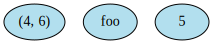

In [17]:
grv = GraphVis()
grv.add_nodes(["foo", 5, (4, 6)])
grv.visualize()


Then, it is possible to add (directed) edges with weights. When the handles are not in the graph, they are automatically added.

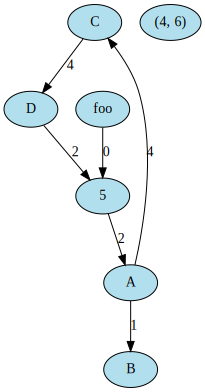

In [18]:
grv.add_edges(
    [("foo", 5), ("A", "B", 1), ("A", "C", 4),
     ("C", "D", 4), ("D", 5, 2), (5, "A", 2)]
)
grv.visualize()


Existing edges can be also safely deleted.

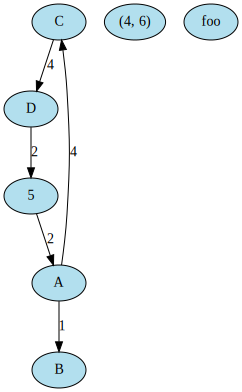

In [19]:
grv.del_edge("foo", 5)
grv.visualize()


If we want to do it again - what is not possible - we get warned.

In [20]:
grv.del_edge("foo", 5)


And the same with nodes.

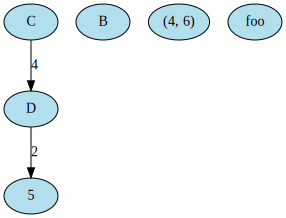

In [21]:
grv.del_node("A")
grv.visualize()


The class alows us to get the lists of nodes and edges.

In [22]:
grv.get_nodes()


{(4, 6), 5, 'B', 'C', 'D', 'foo'}

In [23]:
grv.get_edges()


{(('C', 'D'), 4), (('D', 5), 2)}

Graph size is shown as a current number of nodes and edges.

In [24]:
grv.size()


{'nodes': 6, 'edges': 4}

Moreover, we can check if it contains particular elements and directly iterate over it (over the "keys").

In [25]:
"foo" in grv


True

In [26]:
"bar" in grv


False

In [27]:
for node in grv:
    print(node)


foo
5
(4, 6)
B
C
D


Important feature is also an option to create undirected graphs.

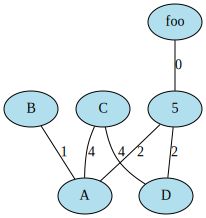

In [28]:
gru = GraphVis(directed=False)
gru.add_edges(
    [("foo", 5), ("A", "B", 1), ("A", "C", 4),
     ("C", "D", 4), ("D", 5, 2), (5, "A", 2)]
)
gru.visualize()


-----------------------

# Task 3

_**Graph searching methods - BFS and DFS**_

-----------------------

Here I added *BFS* and *DFS* methods which change the nodes' properities. Those are the helper methods and are not expected to be used outside the class. Partially inspired by the lecture [[2]](#ref2).

On the other hand, I also added the traversal methods showing the "discovery" and "processing finished" order both for *BFS* and *DFS*. Another usage is finding the shortest path between the given points node by node (regardless the weights). It is also implemented below.

## Graph class with searching methods

In [29]:
class GraphSearch(GraphVis):
    """`GraphBasic` extended with the visualization, traversal and path finding methods.

    Attributes (additional):
        _time (int): Simple time counter to keep the searching order.
        _has_cycles (bool): Information if any edge cycles are in the graph. 
    """

    def __init__(self, directed: bool = True):
        """Create an empty graph.

        Args:
            directed (bool, optional): Version of the graph;
                `True` for directed. Defaults to True.
        """
        super().__init__(directed)
        self._time = 0
        self._has_cycles = False

    def _time_it(self) -> int:
        """Check the current time on the graph's counter clock.

        Returns:
            int: Current graph's time.
        """
        self._time += 1
        return self._time

    def _reset_hdata(self):
        """Reset the helper graph's attributes (time and cycles).
        Reset also the searching helper attributes for each node in the graph. 
        """
        self._time = 0
        self._has_cycles = False
        for node in self._get_nodes_obj():
            node.reset()

    def _mark_bfs(self, start_node: Node):
        """Perform a breadth-first search starting from the given node.
        Mark all the visited nodes properly.

        Args:
            start_node (Node): The node to start searching from.
        """
        start_node.dist = 0
        bfs_queue = queue.SimpleQueue()
        bfs_queue.put_nowait(start_node)

        while not bfs_queue.empty():
            curr_node = bfs_queue.get_nowait()
            for neigh_node in curr_node.neighbors:
                if neigh_node.color == "w":
                    neigh_node.color = "g"
                    neigh_node.disc = self._time_it()
                    neigh_node.dist = curr_node.dist + 1
                    neigh_node.pred = curr_node
                    bfs_queue.put_nowait(neigh_node)
            curr_node.color = "b"
            curr_node.fin = self._time_it()

    def _mark_dfs(self, start_node: Node):
        """Perform a depth-first search starting from the given node.
        Mark all the visited nodes properly.
        Chceck also if there is at least one cycle in the graph.

        Args:
            start_node (Node): The node to start searching from.
        """
        start_node.color = "g"
        start_node.disc = self._time_it()
        for neigh_node in start_node.neighbors:

            # Additional feature - chcecking the cycles OTF
            if neigh_node.color == "g":
                self._has_cycles = True

            if neigh_node.color == "w":
                neigh_node.dist = start_node.dist + 1
                neigh_node.pred = start_node
                self._mark_dfs(neigh_node)
        start_node.color = "b"
        start_node.fin = self._time_it()

    def _traversal(self, start_key: Any, trav_method: function) -> Dict[str, List[Any]]:
        """A helper method to find the traversal orders ("discovered" and "finished-processing").
        Base on the clock times assigned to the nodes.

        Args:
            start_key (Any): The node key to start searching from.
            trav_method (function): BFS or DFS method as a searching function.
                use `self._mark_bfs` or `self._mark_dfs`.

        Raises:
            Exception: Starting point must be an element of the graph.

        Returns:
            Dict[str, List[Any]]: Dictionary of orders for both categories (disc. and fin. as above).
        """
        start_node = self._get_node_obj(start_key)
        if not start_node:
            raise Exception("Start point is not in the graph.")
        self._reset_hdata()
        trav_method(start_node)
        node_list = self._get_nodes_obj()
        disc_times = {
            node.disc: node.key for node in node_list if node.disc != 0}
        fin_times = {node.fin: node.key for node in node_list if node.fin != 0}

        traversal = {
            "discovered": list(map(lambda elem: elem[1], sorted(disc_times.items()))),
            "finished": list(map(lambda elem: elem[1], sorted(fin_times.items()))),
        }
        self._reset_hdata()
        return traversal

    def trav_bfs(self, start_key: Any) -> Dict[str, List[Any]]:
        """Find the traversal order for the BFS method. Start from the given node.

        Args:
            start_key (Any): The node key to start searching from.

        Returns:
            Dict[str, List[Any]]: Dictionary of orders for both categories ("discovered" and "finished-processing").
        """
        return self._traversal(start_key, self._mark_bfs)

    def trav_dfs(self, start_key: Any) -> Dict[str, List[Any]]:
        """Find the traversal order for the DFS method. Start from the given node.

        Args:
            start_key (Any): The node key to start searching from.

        Returns:
            Dict[str, List[Any]]: Dictionary of orders for both categories ("discovered" and "finished-processing").
        """
        return self._traversal(start_key, self._mark_dfs)

    def find_path(self, from_key: Any, to_key: Any) -> List[Any]:
        """Find the step-by-step shortest path between the nodes.
        Ignore the connection costs - only steps number matters.

        Args:
            from_key (Any): Starting node's key - the first point of the path.
            to_key (Any): Ending node's key - the point point of the path.

        Raises:
            Exception: Given nodes must be elements of the graph.
            Exception: Nodes have to be connected to find the path between them.

        Returns:
            List[Any]: All the points in the graph given as the consecutive keys.
        """
        from_node = self._get_node_obj(from_key)
        to_node = self._get_node_obj(to_key)
        if not (from_node and to_node):
            raise Exception("Path points are not in the graph.")
        self._reset_hdata()
        self._mark_bfs(from_node)
        path_list = []
        if to_node.pred:
            curr_node = to_node
            while curr_node:
                path_list.append(curr_node.key)
                curr_node = curr_node.pred

            self._reset_hdata()
            return path_list[::-1]
        else:
            self._reset_hdata()
            raise Exception("Given nodes are not connected.")


## Presentation

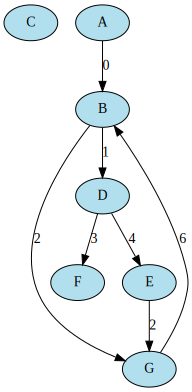

In [30]:
grs = GraphSearch()
grs.add_nodes(["A", "B", "C"])
grs.add_edges(
    [
        ("A", "B"),
        ("B", "D", 1),
        ("D", "E", 4),
        ("D", "F", 3),
        ("E", "G", 2),
        ("G", "B", 6),
        ("B", "G", 2),
    ]
)
grs.visualize()


We have got traversal orders for *BFS* and *DFS* methods. Starting point can be freely chosen.

In [31]:
grs.trav_bfs("B")


{'discovered': ['D', 'G', 'E', 'F'], 'finished': ['B', 'D', 'G', 'E', 'F']}

In [32]:
grs.trav_bfs("B")


{'discovered': ['D', 'G', 'E', 'F'], 'finished': ['B', 'D', 'G', 'E', 'F']}

And here is how to find the path.

In [33]:
grs.find_path("A", "E")


['A', 'B', 'D', 'E']

In [34]:
try:
    grs.find_path("foo", "A")
except Exception as err:
    print(err)


Path points are not in the graph.


-----------------------

# Task 4

_**DFS features modification - topological sorting**_

-----------------------

Next, I added topological sorting method which returns a list of order - if it is only possible. Cycles disenable it.

After sorting - or for any desired subset of graph nodes we can visualise it as a row with connections.

I did not modify the search method as it was in the task, becouse it is already written correctly. 

## Topological sorting in the class

In [35]:
class GraphTopo(GraphSearch):
    """`GraphBasic` extended with the visualization, traversal, path finding and
        sorting methods (along with the custom visualization).
    """

    def topo_sort(self) -> List[Any]:
        """Sort the graph topologically.

        Raises:
            Exception: Only directed graph can be sorted that way.
            Exception: Cycles are forbidden while sorting.

        Returns:
            List[Any]: Sequence of the graph keys in topological order.
        """
        if not self.directed:
            raise Exception("Undirected graph cannot be sorted topologically.")
        self._reset_hdata()
        visit_times = dict()
        for node in self.nodes.values():
            if node.color == "w":
                self._mark_dfs(node)
        if self._has_cycles:
            raise Exception(
                "Graph with cycles cannot be sorted topologically.")
        for key, node in self.nodes.items():
            visit_times[node.fin] = key
        sorted_visits = sorted(visit_times.items(), reverse=True)
        sorted_keys = [tup[1] for tup in sorted_visits]
        self._reset_hdata()
        return sorted_keys

    def vis_line_order(self, subgraph_keys: List[Any]) -> graphviz.graphs.Digraph:
        """Visualize the nodes relation in one line and in the given order.
            It is mainly to analyse selections of the nodes from the graph. 

        Args:
            subgraph_keys (List[Any]): List of keys to visualize the relation.

        Raises:
            Exception: Only directed graph can be visualized that way.  
                (Only a convention).
            Exception: To visualize the nodes they must be elements of the graph. 

        Returns:
            graphviz.graphs.Digraph: Graph object in `dot` language.
        """
        if not self.directed:
            raise Exception("Undirected graph cannot be visualized this way.")
        for key in subgraph_keys:
            if key not in self.get_nodes():
                raise Exception("Invalid nodes on the list.")

        dot = graphviz.Digraph()
        dot.attr("node", style="filled", fillcolor="lightblue2")
        for key in subgraph_keys:
            dot.node(str(key))
        for node_keys, weight in self.get_edges():
            from_node, to_node = list(node_keys)
            if from_node in subgraph_keys and to_node in subgraph_keys:
                edge_data = list(map(str, [from_node, to_node]))
                dot.edge(*edge_data, constraint="false")

        return dot


## Presentation

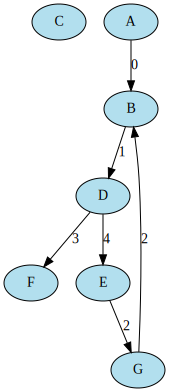

In [36]:
grt = GraphTopo()
grt.add_nodes(["A", "B", "C"])
grt.add_edges(
    [
        ("A", "B"),
        ("B", "D", 1),
        ("D", "E", 4),
        ("D", "F", 3),
        ("E", "G", 2),
        ("G", "B", 2),
    ]
)
grt.visualize()


The structure above cannot be sorted because of its cycle.

In [37]:
try:
    grt.topo_sort()
except Exception as err:
    print(err)


Graph with cycles cannot be sorted topologically.


If we remove one edge, the operation can be performed. 

In [38]:
grt.del_edge("G", "B")
topo_sorted = grt.topo_sort()
topo_sorted


['C', 'A', 'B', 'D', 'F', 'E', 'G']

Then, visualize it.

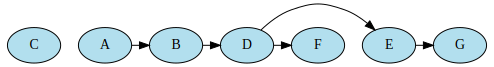

In [39]:
grt.vis_line_order(topo_sorted)


As it was mentioned, we can visualise only a "subgraph" with its connenctions.

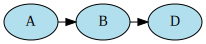

In [40]:
grt.vis_line_order(["A", "D", "B"])


However, the given nodes must be valid.

In [41]:
try:
    grs.vis_line_order(["A", "foo", "B"])
except Exception as err:
    print(err)


'GraphSearch' object has no attribute 'vis_line_order'


-----------------------

# Task 5

_**Optimal paths between the nodes**_

-----------------------

In this task I have added a Dijkstra path finder algorithm. The method which uses it can evaluate the shortest paths to all the nodes, begining from the given one (if only they are connected).

## Shortest path finder added

In [42]:
class GraphPaths(GraphTopo):
    """`GraphBasic` extended with the visualization, traversal, path finding,
        sorting methods (along with the custom visualization) and the shortest
            paths length evaluation algorithm (Dijkstra; regarding the weights).
    """

    def _dijkstra(self, start_node: Node):
        """Perform a Dijkstra algorithm and mark all the visited nodes
            with the shortest weighted distance from the starting node. 

        Args:
            start_node (Node): Node to start searching from.
        """
        start_node.dist = 0
        priors = {node: node.dist for node in self._get_nodes_obj()}
        start_node.color = "b"
        while priors:
            curr_node = min(priors.keys(), key=(lambda k: priors[k]))
            priors.pop(curr_node)
            for neigh_node in curr_node.neighbors:
                new_dist = curr_node.dist + curr_node.get_weight(neigh_node)
                if new_dist < neigh_node.dist:
                    neigh_node.dist = new_dist
                    neigh_node.pred = curr_node
                    priors[neigh_node] = new_dist
                neigh_node.color = "b"

    def opt_paths_len(self, start_key: Any) -> Dict[Any, float]:
        """Find the shortest paths to all the nodes starting from the given one.
        Consider the connection costs.

        Args:
            start_key (Any): Key of the node to start searching from.

        Raises:
            Exception: The start node must be an element of the graph.

        Returns:
            Dict[Any, float]: Nodes with their shortest path weighted distances.
                (`None` if there is no connection)
        """
        start_node = self._get_node_obj(start_key)
        if not start_node:
            raise Exception("Start point is not in the graph.")
        self._reset_hdata()
        self._dijkstra(start_node)
        distances = {
            node.key: node.dist for node in self._get_nodes_obj() if node.color == "b"
        }
        distances_undisc = {
            node.key: None for node in self._get_nodes_obj() if node.color != "b"
        }
        distances.update(distances_undisc)
        return distances


## Presentation

We see that the shorter path sometime consists of more nodes and that unconnected nodes have no path length assigned.

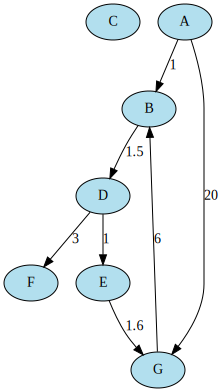

In [43]:
grp = GraphPaths()
grp.add_node("C")
grp.add_edges(
    [
        ("A", "B", 1),
        ("B", "D", 1.5),
        ("D", "E", 1),
        ("D", "F", 3),
        ("E", "G", 1.6),
        ("G", "B", 6),
        ("A", "G", 20),
    ]
)
grp.visualize()


And:

In [44]:
grp.opt_paths_len("B")


{'G': 4.1, 'B': 0, 'F': 4.5, 'E': 2.5, 'D': 1.5, 'C': None, 'A': None}

-----------------------

# Final `Graph` class

-----------------------

A `Graph` class will be used in the next tasks, so there is the final inheriting product with a simple, ulitmate name.

In [45]:
class Graph(GraphPaths):
    """A graph class with the complex node management support,
        various searching, sorting and visualization methods and
        enabling to find the shortest paths and the shortest weighted distances.

    Inherits from the sequence of graph classes and states for a final product.

    Attributes:
        nodes (dict): Node keys and references to their objects.
        node_count (int): Current number of nodes.
        edge_count (int): Current number of edges.
        directed (bool): Information about being a directed/undirected graph.
        _time (int): Simple time counter to keep the searching order.
        _has_cycles (bool): Information if any edge cycles are in the graph. 

    """
    pass


-----------------------

# Task 6

_**"Missionaries and cannibals" problem**_

-----------------------

## Riversides represenation with missionaries, cannibals and a boat

The situation is represented by the class. We have got 3 missionaries and 3 cannibals, distributed on two sides and the boat can be also on the left or right side.

We can transit one or two people to the other side and check if the missionaries are safe from being eaten.

Hashing is also supported, because it is essential to compare the states later.

In [133]:
class Riversides:
    """[summary]
    """
    def __init__(
        self,
        left_mis: int = 3,
        left_can: int = 3,
        right_mis: int = 0,
        right_can: int = 0,
        boat_left: str = True,
    ):
        groups = [left_mis, left_can, right_mis, right_can]
        if not all(map(lambda grp: isinstance(grp, int), groups)):
            raise TypeError("Volumes have to be integers.")
        if all([0 <= grp <= 3 for grp in groups]):
            self._left_mis = left_mis
            self._left_can = left_can
            self._right_mis = right_mis
            self._right_can = right_can
            self._boat_left = boat_left
        else:
            raise Exception("Invalid volumes.")

    def _transit(self, boat=Tuple[int]) -> Optional[Riversides]:
        if self._boat_left:
            new_left_mis = self._left_mis - boat[0]
            new_left_can = self._left_can - boat[1]
            new_right_mis = self._right_mis + boat[0]
            new_right_can = self._right_can + boat[1]
        else:
            new_left_mis = self._left_mis + boat[0]
            new_left_can = self._left_can + boat[1]
            new_right_mis = self._right_mis - boat[0]
            new_right_can = self._right_can - boat[1]

        groups = [new_left_mis, new_left_can, new_right_mis, new_right_can]
        if all([0 <= grp <= 3 for grp in groups]):
            return Riversides(
                new_left_mis,
                new_left_can,
                new_right_mis,
                new_right_can,
                not self._boat_left,
            )
        else:
            return None

    def do_actions(self) -> List[Riversides]:
        transit_options = [(1, 1), (2, 0), (0, 2), (1, 0), (0, 1)]
        moves = [self._transit(boat) for boat in transit_options]
        legal_moves = list(filter(None, moves))
        return legal_moves

    def is_safe(self) -> bool:
        condit_left = self._left_mis >= self._left_can or not self._left_mis
        condit_right = self._right_mis >= self._right_can or not self._right_mis
        if condit_left and condit_right:
            return True
        return False

    def __str__(self) -> str:
        return "M-{lm} C-{lc}; M-{rm} C-{rc}".format(
            lm=str(self._left_mis),
            lc=str(self._left_can),
            rm=str(self._right_mis),
            rc=str(self._right_can),
        )

    def __repr__(self) -> str:
        return "Riversides(left({lm}, {lc}), right({rm}, {rc}))".format(
            lm=str(self._left_mis),
            lc=str(self._left_can),
            rm=str(self._right_mis),
            rc=str(self._right_can),
        )

    def __eq__(self, other):
        if type(other) is type(self):
            condits = [
                self._left_mis == other._left_mis,
                self._left_can == other._left_can,
                self._right_mis == other._right_mis,
                self._right_can == other._right_can,
                self._boat_left == other._boat_left,
            ]
            return all(condits)
        else:
            return False

    def __hash__(self):
        return hash(
            (
                self._left_mis,
                self._left_can,
                self._right_mis,
                self._right_can,
                self._boat_left,
            )
        )


## Solving functions

At firtst the graph is built. For each state the new possible states are evaluated and if missionaries are alive we continue that process until we are run out of the new options.

In [134]:
def river_build_graph() -> Graph:
    river_graph = Graph()
    init_condit = Riversides()
    river_graph.add_node(init_condit)

    def branch(curr_state: Riversides):
        new_states = curr_state.do_actions()
        for state in new_states:
            is_new = not (state in river_graph.get_nodes())
            river_graph.add_edge(curr_state, state, 1)
            if is_new and state.is_safe():
                branch(state)

    branch(init_condit)
    return river_graph


Then the path have to be found.

In [135]:
def find_river_steps() -> List[Riversides]:
    river_graph = river_build_graph()
    std_init = Riversides()
    path = None
    for node in river_graph.get_nodes():
        if node == Riversides(0, 0, 3, 3, False):
            path = river_graph.find_path(std_init, node)
    return path


## Visualization

Before the solution I show the graph representation of the problem.

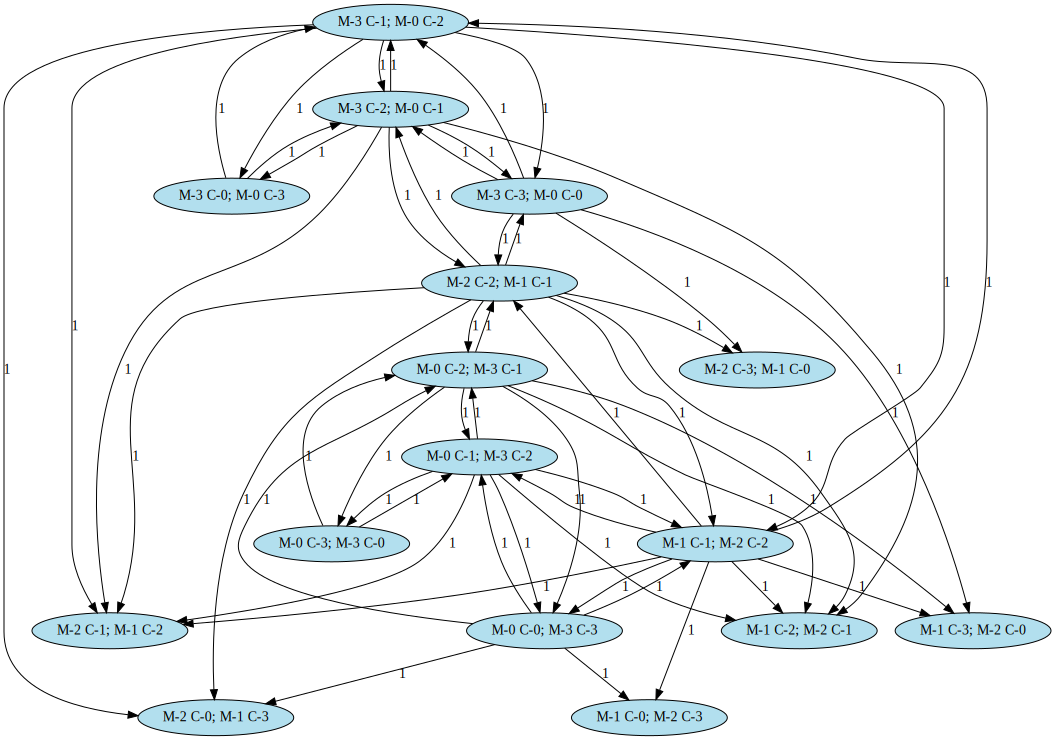

In [136]:
river_graph = river_build_graph()
river_graph.visualize()


## Solution

In [139]:
find_river_steps()


[Riverside(left(3, 3), right(0, 0)),
 Riverside(left(2, 2), right(1, 1)),
 Riverside(left(3, 2), right(0, 1)),
 Riverside(left(3, 0), right(0, 3)),
 Riverside(left(3, 1), right(0, 2)),
 Riverside(left(1, 1), right(2, 2)),
 Riverside(left(2, 2), right(1, 1)),
 Riverside(left(0, 2), right(3, 1)),
 Riverside(left(0, 3), right(3, 0)),
 Riverside(left(0, 1), right(3, 2)),
 Riverside(left(1, 1), right(2, 2)),
 Riverside(left(0, 0), right(3, 3))]

Having named a missionary as "M" and a cannibal as "C", for example the shortest solution is to move:

* $\rightarrow\quad$ M and C
* $\leftarrow\quad$ M
* $\rightarrow\quad$ C and C
* $\leftarrow\quad$ C
* $\rightarrow\quad$ M and M
* $\leftarrow\quad$M and C
* $\rightarrow\quad$ M and M
* $\leftarrow\quad$ C
* $\rightarrow\quad$ C and C
* $\leftarrow\quad$ M
* $\rightarrow\quad$ M and C


-----------------------

# Task 7

_**"Water in buckets" problem**_

-----------------------

## Buckets representation 

For creating the current state volumes and maximal volumes in both buckets must be given. There are also six action possibilites to do with the water:

* filling the bucket,
* emptying the bucket,
* pouring the water from one to another.

We can also check the total volume in the system. The rest of the class is similar to the one in the task before.

In [140]:
class TwoBucketSet:
    def __init__(self, left: int, right: int, left_max: int, right_max: int):
        if not all(
            map(lambda v: isinstance(v, int), [
                left, right, left_max, right_max])
        ):
            raise TypeError("Volumes have to be integers.")
        if 0 <= left <= left_max and 0 <= right <= right_max:
            self._left = left
            self._right = right
            self._left_max = left_max
            self._right_max = right_max
        else:
            raise Exception("Invalid volumes.")

    def fill_left(self) -> Optional[TwoBucketSet]:
        if self._left != self._left_max:
            return TwoBucketSet(
                self._left_max,
                self._right,
                self._left_max,
                self._right_max,
            )
        else:
            return None

    def fill_right(self) -> Optional[TwoBucketSet]:
        if self._right != self._right_max:
            return TwoBucketSet(
                self._left,
                self._right_max,
                self._left_max,
                self._right_max,
            )
        else:
            return None

    def spill_left(self) -> Optional[TwoBucketSet]:
        if self._left != 0:
            return TwoBucketSet(0, self._right, self._left_max, self._right_max)
        else:
            return None

    def spill_right(self) -> Optional[TwoBucketSet]:
        if self._right != 0:
            return TwoBucketSet(self._left, 0, self._left_max, self._right_max)
        else:
            return None

    def pour_to_left(self) -> Optional[TwoBucketSet]:
        left_diff = self._left_max - self._left
        if left_diff and self._right:
            poured = min(left_diff, self._right)
            new_left = self._left + poured
            new_right = self._right - poured
            return TwoBucketSet(new_left, new_right, self._left_max, self._right_max)
        else:
            return None

    def pour_to_right(self) -> Optional[TwoBucketSet]:
        right_diff = self._right_max - self._right
        if right_diff and self._left:
            poured = min(right_diff, self._left)
            new_left = self._left - poured
            new_right = self._right + poured
            return TwoBucketSet(new_left, new_right, self._left_max, self._right_max)
        else:
            return None

    def do_actions(self):
        moves = [
            self.fill_left(),
            self.fill_right(),
            self.spill_left(),
            self.spill_right(),
            self.pour_to_left(),
            self.pour_to_right(),
        ]
        legal_moves = list(filter(None, moves))
        return legal_moves

    def total_vol(self) -> int:
        return self._left + self._right

    def __str__(self) -> str:
        return ", ".join(map(str, [self._left, self._right]))

    def __repr__(self) -> str:
        return "TwoBucketSet(({l}, {r}), of({lm}, {rm}))".format(
            l=str(self._left),
            r=str(self._right),
            lm=str(self._left_max),
            rm=str(self._right_max),
        )

    def __eq__(self, other):
        if type(other) is type(self):
            condits = [
                self._left == other._left,
                self._right == other._right,
                self._left_max == other._left_max,
                self._right_max == other._right_max,
            ]
            return all(condits)
        else:
            return False

    def __hash__(self):
        return hash((self._left, self._right, self._left_max, self._right_max))


## Solving functions

These functions are enhanced versions of the ones form the previous task.

In [141]:
def bucket_build_graph(max_vol_a: int, max_vol_b: int) -> Graph:
    bucket_graph = Graph()
    init_condit = TwoBucketSet(0, 0, max_vol_a, max_vol_b)
    bucket_graph.add_node(init_condit)

    def branch(curr_state: TwoBucketSet):
        new_states = curr_state.do_actions()
        for state in new_states:
            is_new = not (state in bucket_graph.get_nodes())
            bucket_graph.add_edge(curr_state, state, 1)
            if is_new:
                branch(state)

    branch(init_condit)
    return bucket_graph


However in this case there can be more than one final node (different combination of the same total volume exist):

In [142]:
def find_bucket_steps(
    max_vol_a: int, max_vol_b: int, des_vol: int
) -> List[TwoBucketSet]:
    bucket_graph = bucket_build_graph(max_vol_a, max_vol_b)
    paths = []
    std_init = TwoBucketSet(0, 0, max_vol_a, max_vol_b)
    for node in bucket_graph.get_nodes():
        if node.total_vol() == des_vol:
            paths.append(bucket_graph.find_path(std_init, node))
    if paths:
        opt_path = sorted(paths, key=len)[0]
        return opt_path
    else:
        return None


## Visualization

Before the function is called, we assign the capacities and the desired volume. 

In [ ]:
MAX_VOL_A = 3
MAX_VOL_B = 4
DES_VOL = 2


Ad the rest is just analogous.

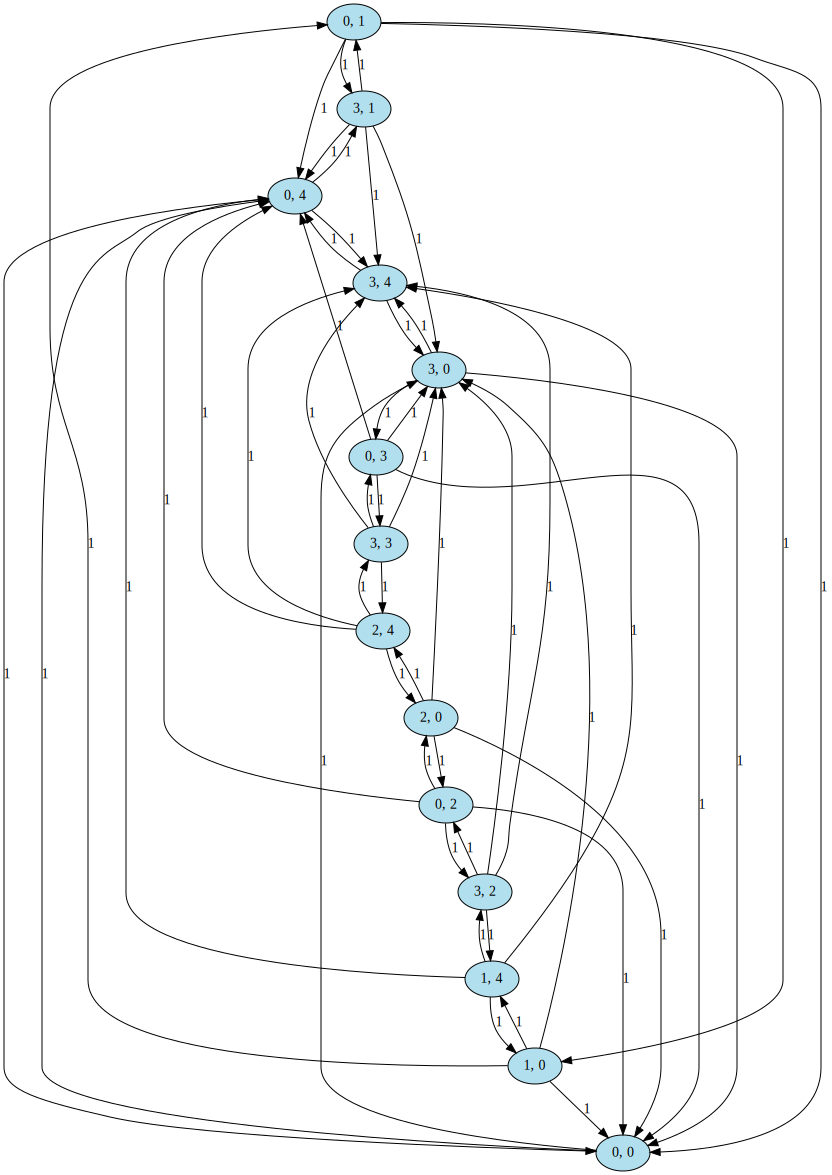

In [144]:
bucket_graph = bucket_build_graph(MAX_VOL_A, MAX_VOL_B)
bucket_graph.visualize()


## Solution

In [145]:
find_bucket_steps(MAX_VOL_A, MAX_VOL_B, DES_VOL)


[TwoBucketSet((0, 0), of(3, 4)),
 TwoBucketSet((3, 0), of(3, 4)),
 TwoBucketSet((0, 3), of(3, 4)),
 TwoBucketSet((3, 3), of(3, 4)),
 TwoBucketSet((2, 4), of(3, 4)),
 TwoBucketSet((2, 0), of(3, 4))]

That means we can e.g.:

* Fill the 3l bucket,
* Pour this water to the 4l bucket,
* Fill the 3l bucket again,
* Pour the water to the 4l bucket (now we pour only 1l),
* Spill the water from the 4l bucket.

The amount which stays in the system is 2l - that is the end. Moreover, there is also no shorter path.

-----------------------

# References

-----------------------

<a id="ref1">[1]</a> J. Szwabiński, *Wykład 10 - Grafy i podstawowe algorytmy grafowe*,  *Algorytmy i struktury danych*, p. 2-16. [accessed: 24.01.2022]. Link: http://prac.im.pwr.wroc.pl/~szwabin/assets/algo/lectures/10.pdf.

<a id="ref2">[2]</a> J. Szwabiński, *Wykład 11 - Grafy i podstawowe algorytmy grafowe (ciąg dalszy)*,  *Algorytmy i struktury danych*, p. 9-19. [accessed: 24.01.2022]. Link: http://prac.im.pwr.wroc.pl/~szwabin/assets/algo/lectures/11.pdf.


-----------------------